In [2]:
#imports and settings
import pandas as pd 
pd.set_option('display.expand_frame_repr', False)
import numpy as np
from matplotlib import pyplot as plt 
plt.style.use('fivethirtyeight')
from patsy import dmatrices
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('loan.csv', low_memory = False)

In [4]:
#Returns a random sample of items - 30% so the dataset is easy to work with
df_sample = df.sample(frac = 0.3)
df_sample.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
827859,41339724,44246512,30000.0,30000.0,29975.0,60 months,15.61,723.34,D,D1,...,NaN,NaN,NaN,NaN,NaN,NaN,42900.0,NaN,NaN,NaN
384702,16592426,18704940,10000.0,10000.0,10000.0,60 months,10.99,217.38,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,63300.0,NaN,NaN,NaN


In [5]:
#Analyzing target variable - loan_status
df_sample['loan_status'].value_counts()

Current                                                180670
Fully Paid                                              62393
Charged Off                                             13452
Late (31-120 days)                                       3374
Issued                                                   2487
In Grace Period                                          1892
Late (16-30 days)                                         732
Does not meet the credit policy. Status:Fully Paid        619
Default                                                   363
Does not meet the credit policy. Status:Charged Off       232
Name: loan_status, dtype: int64

In [6]:
#getting rid of loans with statuses we do not care about
#we do not care about current loans 
#explanation of difference between charged off and default https://help.lendingclub.com/hc/en-us/articles/216127747
#we only care about those loans that are either fully paid or are
#very late
#too little examples with "does not meet the credit policy" to care about these...
mask = df_sample['loan_status'].isin(['Fully Paid','Charged Off','Default'])
df_sample = df_sample[mask]
df_sample['loan_status'].value_counts()


Fully Paid     62393
Charged Off    13452
Default          363
Name: loan_status, dtype: int64

In [7]:
# now we only work with loans that are either fully paid or late > 121 days
# We create target variable with these two possible values. Positive class
# are late loans - we care about these and want to analyze in detail. 

def CreateTarget(status): 
    if status == 'Fully Paid':
        return 0
    else:
        return 1
    
df_sample['Late_Loan'] = df_sample['loan_status'].map(CreateTarget)
df_sample['Late_Loan'].value_counts()

0    62393
1    13815
Name: Late_Loan, dtype: int64

In [8]:
#drop features with more than 25% missing values
features_missing_series = df_sample.isnull().sum() > len(df_sample)/10
features_missing_series = features_missing_series[features_missing_series == True]
features_missing_list =  features_missing_series.index.tolist()
df_sample = df_sample.drop(features_missing_list,axis =1)

# drop features that have no or little predictive power and original target
df_sample = df_sample.drop(['id','member_id','loan_status','url','zip_code','policy_code','application_type','last_pymnt_d','last_credit_pull_d','verification_status','pymnt_plan','funded_amnt','funded_amnt_inv','sub_grade','out_prncp','out_prncp_inv','total_pymnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','initial_list_status','earliest_cr_line'],axis =1)

#replace missing values with Unknown value or mean when feature is numerical
df_sample['emp_title'].fillna('Unknown',inplace = True)
df_sample['title'].fillna('Unknown',inplace = True)
df_sample['revol_util'].fillna(df_sample['revol_util'].mean(),inplace = True)
df_sample['collections_12_mths_ex_med'].fillna(df_sample['collections_12_mths_ex_med'].mean(),inplace = True)

df_sample.isnull().sum() #there are no missing values left 

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
issue_d                       0
purpose                       0
title                         0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
collections_12_mths_ex_med    0
acc_now_delinq                0
Late_Loan                     0
dtype: int64

In [9]:
#old categorical emp_length feature
df_sample['emp_length'].value_counts()

10+ years    23170
2 years       7095
< 1 year      6292
3 years       6143
5 years       5452
1 year        5121
4 years       4845
6 years       4428
7 years       4289
8 years       3519
n/a           2988
9 years       2866
Name: emp_length, dtype: int64

In [10]:
#new numerical emp_length feature

def EmpLength(year):
    if year == '< 1 year':
        return 0.5
    elif year == 'n/a': #assuming that if not filled out employments was < 1 
        return 0.5
    elif year == '10+ years':
        return 10
    else:
        return float(year.rstrip(' years'))
        
df_sample['emp_length_num'] = df_sample['emp_length'].map(EmpLength)
df_sample = df_sample.drop('emp_length',axis =1 )
df_sample['emp_length_num'].value_counts()

10.0    23170
0.5      9280
2.0      7095
3.0      6143
5.0      5452
1.0      5121
4.0      4845
6.0      4428
7.0      4289
8.0      3519
9.0      2866
Name: emp_length_num, dtype: int64

In [11]:
#transforming to date datatype
df_sample['issue_d'] = pd.to_datetime(df_sample.issue_d)

In [12]:
#datatypes of features 
# object = string ? 
df_sample.dtypes.value_counts()

float64           15
object             7
datetime64[ns]     1
int64              1
dtype: int64

In [13]:
#cleaned and transformed data ready for analysis and ML 
#numerical features - means 
print(df_sample.select_dtypes(include=['float64']).apply(np.mean).apply(str))

# categorical variables 
print(df_sample.select_dtypes(include=['object']).columns)

# target variable - boolean

print(df_sample.select_dtypes(include=['bool']).columns)

df_sample['purpose'].value_counts()

loan_amnt                         13575.67446987193
int_rate                         13.744478007558783
installment                      418.43580149064337
annual_inc                        72497.73515024656
dti                                16.5925153527189
delinq_2yrs                     0.25076107495276084
inq_last_6mths                   0.8476669116103296
open_acc                         10.971774616838127
pub_rec                         0.14150745328574427
revol_bal                        15248.507991287004
revol_util                       54.401429152987895
total_acc                        25.128228007558263
collections_12_mths_ex_med      0.00700824190246207
acc_now_delinq                0.0030967877388200712
emp_length_num                    5.658946567289523
dtype: object
Index(['term', 'grade', 'emp_title', 'home_ownership', 'purpose', 'title',
       'addr_state'],
      dtype='object')
Index([], dtype='object')


debt_consolidation    44638
credit_card           15215
home_improvement       4518
other                  4312
major_purchase         1847
small_business         1423
car                    1082
medical                 845
moving                  609
wedding                 556
house                   509
vacation                471
educational              94
renewable_energy         89
Name: purpose, dtype: int64

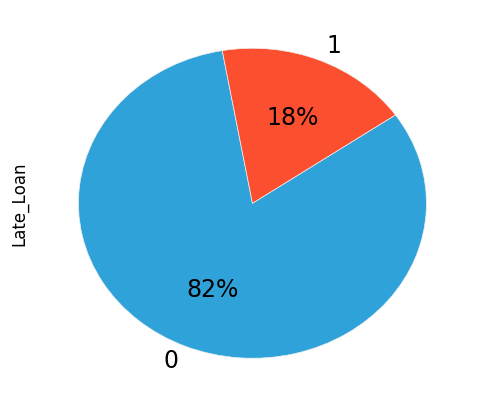

In [14]:
#distribution of our class/targer variable Late_Loan , True if loan is late. 
plt.figure(figsize=(5,5))
df_sample['Late_Loan'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)
plt.show()

In [15]:
Amount_By_Year = df_sample.groupby(df_sample['issue_d'].dt.year)['loan_amnt'].mean()
Amount_By_Year = pd.DataFrame(Amount_By_Year)
Amount_By_Year['YoY Change %'] = Amount_By_Year.pct_change()*100
Amount_By_Year.rename(columns = {'loan_amnt':'Average Loan Amount'})

,Average Loan Amount,YoY Change %
issue_d,,
2007,8464.179104,NaN
2008,9182.632094,8.488159
2009,9830.083213,7.050823
2010,10771.255794,9.574411
2011,11548.630536,7.217123
2012,12915.668837,11.837233
2013,14438.740734,11.792435
2014,14254.155386,-1.278403
2015,14465.957721,1.485899


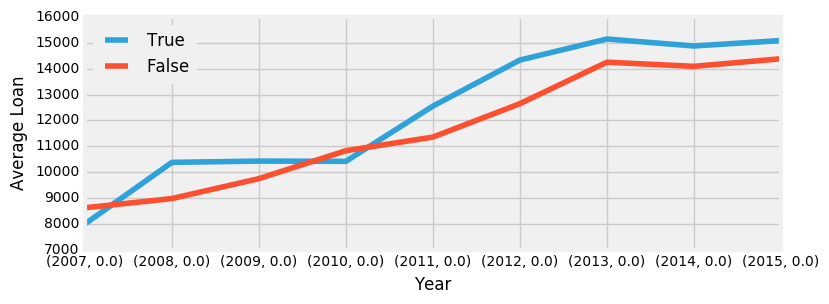

In [16]:
plt.figure(figsize=(8,3))
Amount_By_Year_Status_True = df_sample.groupby([df_sample['issue_d'].dt.year,df_sample['Late_Loan'][df_sample['Late_Loan'] == True]])['loan_amnt'].mean().plot(kind = 'line', label = 'True')
Amount_By_Year_Status_False = df_sample.groupby([df_sample['issue_d'].dt.year,df_sample['Late_Loan'][df_sample['Late_Loan'] == False]])['loan_amnt'].mean().plot(kind = 'line',label = 'False')
plt.xlabel('Year')
plt.ylabel('Average Loan')
plt.legend(loc='best')
plt.show()


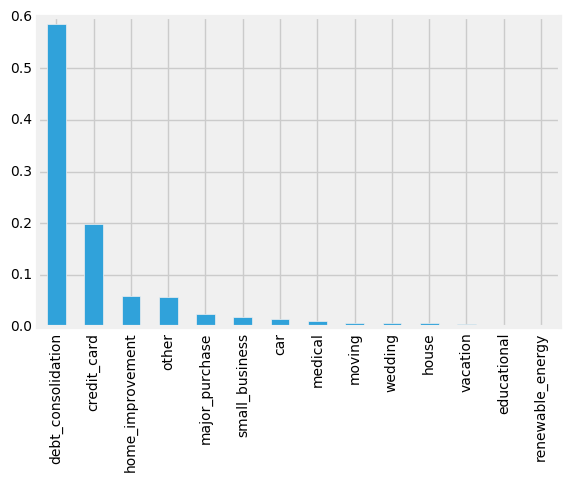

In [17]:
#This graph normalizes the purpose variables, using value counts.
#This gives us an idea of what percentage and purpose the clients are taking out loans for.
all_rows = df_sample['purpose']
pur = df_sample['purpose'].value_counts()
purp = pur/len(all_rows)
purp.plot(kind='bar')

In [18]:
flat = pur/len(df_sample['purpose']) * 100
print(flat)

debt_consolidation    58.573903
credit_card           19.965096
home_improvement       5.928511
other                  5.658199
major_purchase         2.423630
small_business         1.867258
car                    1.419798
medical                1.108807
moving                 0.799129
wedding                0.729582
house                  0.667909
vacation               0.618045
educational            0.123347
renewable_energy       0.116786
Name: purpose, dtype: float64


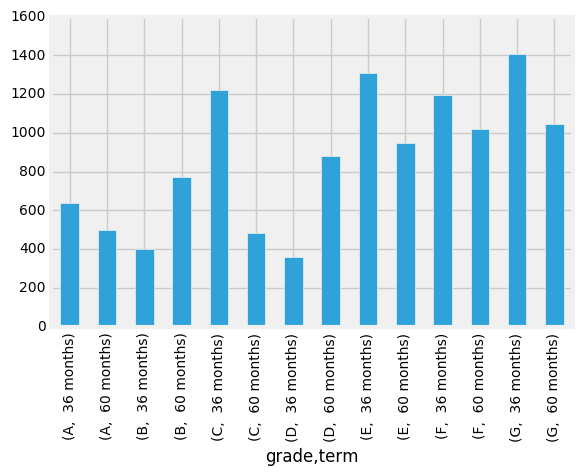

In [19]:
#I'm going to look at the installment payments against the grade and term of the loan.
#This pivot table shows the installment payments by grade and term.
loan_g = pd.pivot_table(df_sample,
                           index= ['grade','term'],
                           columns= ['installment'] ,
                            values= 'loan_amnt',
                           aggfunc = sum)
loan_g.T.idxmax()
loan_g.T.idxmax().plot(kind='bar')

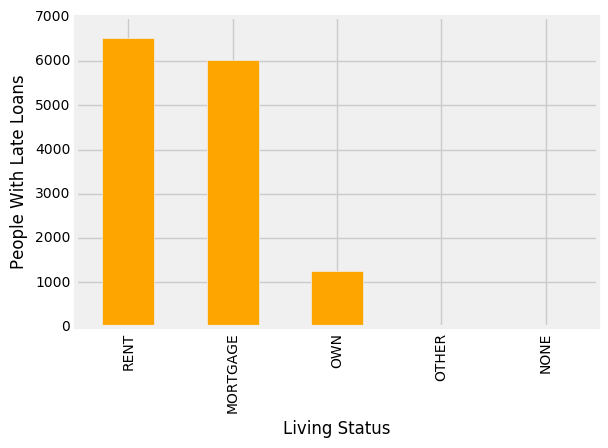

In [20]:
#This graph looks at the people who are late on their loans, renters and people paying their mortages tend to be late on payments
#A possible reason may be that the owners, others, and none may not have a financial burden.
late = df_sample[['home_ownership', 'Late_Loan']]
late_people = late['Late_Loan']== True
people = late[late_people]
sad = people['home_ownership'].value_counts().plot(kind='bar', color= 'orange')
xlabel('Living Status')
ylabel('People With Late Loans')

13.744478007558783


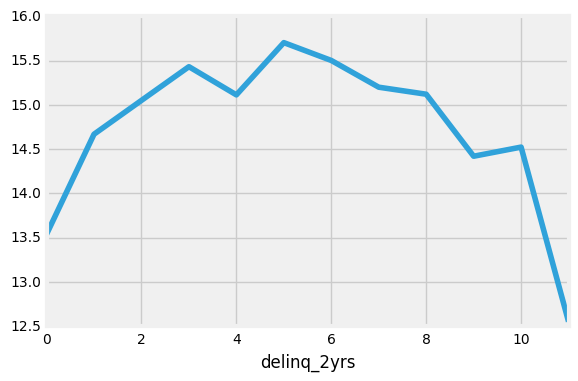

0.0     63988
1.0      8455
2.0      2282
3.0       786
4.0       325
5.0       170
6.0        82
7.0        42
8.0        25
9.0        17
11.0       10
10.0        8
12.0        7
14.0        5
15.0        3
18.0        2
19.0        1
Name: delinq_2yrs, dtype: int64

In [21]:
print(df_sample['int_rate'].mean())
mask_delinq = df_sample['delinq_2yrs'] <= 11
df_sample.groupby(df_sample['delinq_2yrs'][mask_delinq])['int_rate'].mean().plot(kind='line')
plt.show()

df_sample['delinq_2yrs'].value_counts()


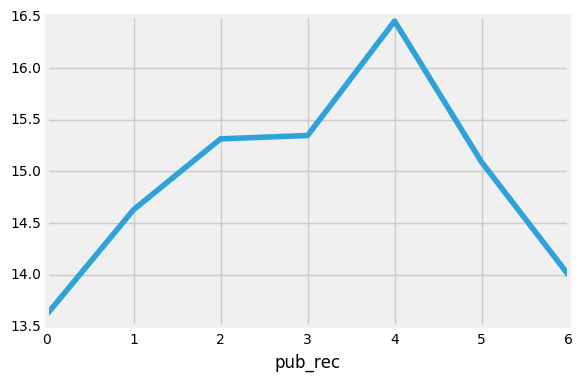

In [22]:
mask_pub_rec = df_sample['pub_rec'] <= 6
df_sample.groupby(df_sample['pub_rec'][mask_pub_rec])['int_rate'].mean().plot(kind='line')
plt.show()

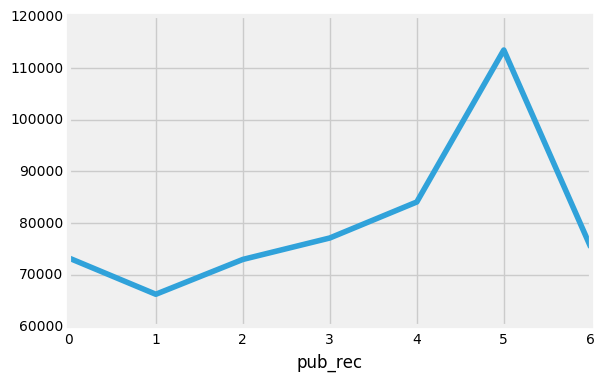

In [23]:
mask_pub_rec = df_sample['pub_rec'] <= 6
df_sample.groupby(df_sample['pub_rec'][mask_pub_rec])['annual_inc'].mean().plot(kind='line')
plt.show()

In [24]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

df_sample['installmentAsPercent'] = df_sample['installment']/(df['annual_inc']/12)

def GradeInt(x):
    if x == "A":
        return 1
    elif x == "B":
        return 2
    elif x == "C":
        return 3
    elif x == "D":
        return 4
    elif x == "E":
        return 5
    else:
        return 6

df_sample['GradeInt'] = df_sample['grade'].map(GradeInt)


Y,X = dmatrices('Late_Loan ~ 0 + int_rate + GradeInt + loan_amnt + installment + annual_inc + dti + delinq_2yrs + inq_last_6mths + open_acc + pub_rec + revol_bal + revol_util + total_acc + collections_12_mths_ex_med + acc_now_delinq + emp_length_num + term  + home_ownership + purpose + installmentAsPercent',df_sample, return_type = 'dataframe')
X_columns = X.columns

sm = SMOTE(random_state=42)
X, Y = sm.fit_sample(X, Y)
X = pd.DataFrame(X,columns=X_columns)

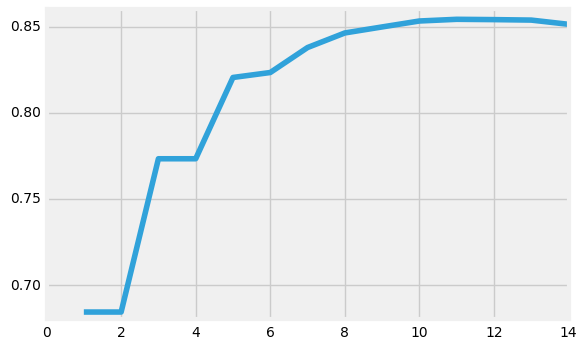

In [25]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)
best_model = []

for i in range(1,15):
    model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=i)    
    kfold = StratifiedKFold(n_splits= 10, shuffle = True)
    scores = cross_val_score(model, X_train, Y_train, cv = kfold )
    best_model.append(scores.mean())

plt.plot(range(1,15),best_model)
plt.show()

In [26]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
param_dist = {    "max_depth": sp_randint(6,10),
                  "max_features": sp_randint(3,15),
                  "max_leaf_nodes": [10,20,30,40,50],
                  "min_samples_leaf": [25,50,75,100,150,250,500],
                 }
random_search = RandomizedSearchCV(model,
                        param_distributions=param_dist,
                        n_iter=50)

random_search.fit(X_train, Y_train)
print(random_search.best_score_)
print(random_search.best_estimator_)

0.8247166571265026
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=12, max_leaf_nodes=50, min_impurity_split=1e-07,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


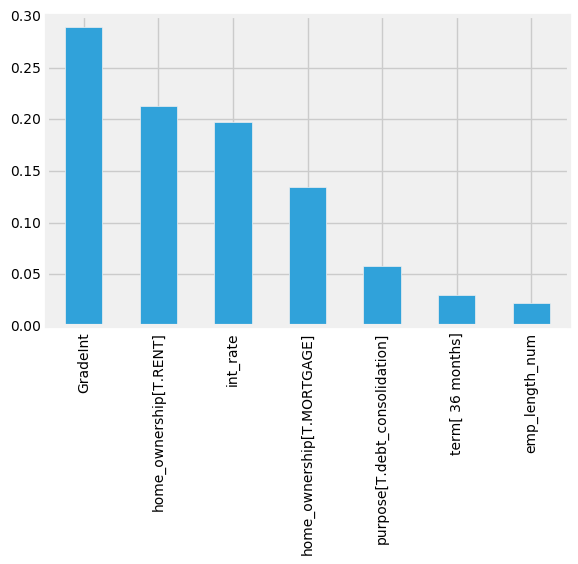

In [61]:
best_model = random_search.best_estimator_
best_model.fit(X_train,Y_train)

importance = sorted(zip(map(lambda x: round(x, 4), best_model.feature_importances_), X.columns),reverse=True)
y_val = []
x_val = [x[0] for x in importance]
for x in importance:
    y_val.append(x[1])
    
pd.Series(x_val,index=y_val)[:7].plot(kind='bar')
plt.show()

0.864969548029
0.763560276839
0.956451612903
[[14232  4407]
 [  648 18149]]


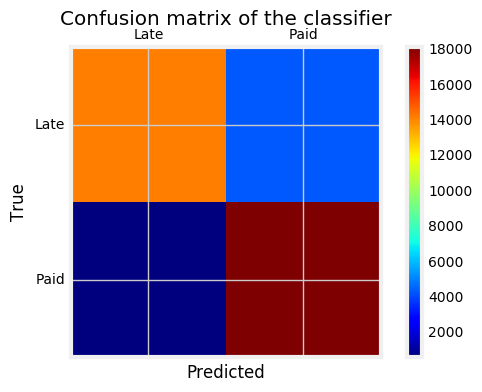

In [65]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(best_model, random_state=1)
bagging.fit(X,Y)

accuracy = metrics.accuracy_score(bagging.predict(X_test),Y_test)
precision = metrics.precision_score(bagging.predict(X_test),Y_test,pos_label=1)
recall = metrics.recall_score(bagging.predict(X_test),Y_test,pos_label=1)
confusion_matrix = metrics.confusion_matrix(Y_test,bagging.predict(X_test),labels=[1,0])

print(accuracy)
print(precision)
print(recall)
print(confusion_matrix)

labels = ['Late', 'Paid']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix)
fig.colorbar(cax)
plt.title('Confusion matrix of the classifier')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

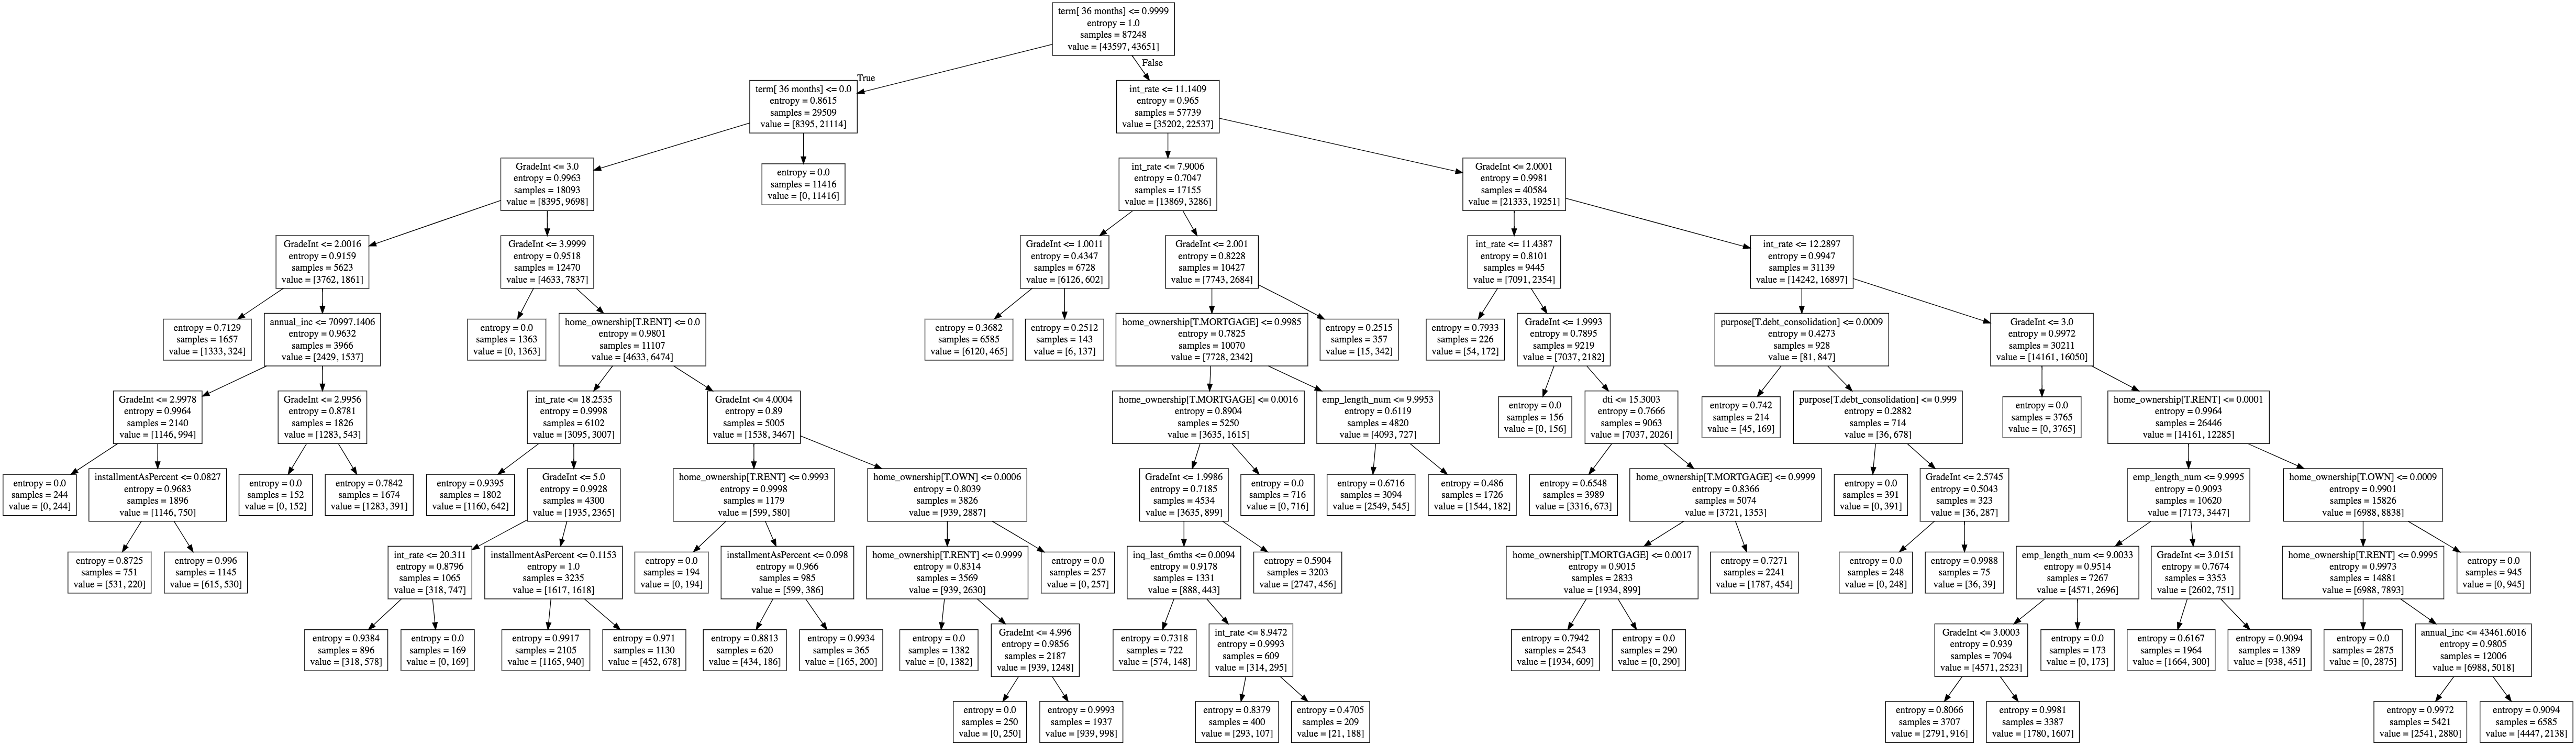

In [70]:
tree.export_graphviz(best_model,feature_names=X.columns) 
from IPython.core.display import Image, display
display(Image('https://raw.githubusercontent.com/jakubkudela/images/11e140a0de017a78799838cbf03688763e0340ae/1.png', width=1900, unconfined=True))